# Regresión con Redes Neuronales

Empleando diferentes *funciones de pérdida* y *funciones de activación* las **redes neuronales** pueden resolver
efectivamente problemas de **regresión.**
En esta libreta se estudia el ejemplo de [California Housing](http://www.spatial-statistics.com/pace_manuscripts/spletters_ms_dir/statistics_prob_lets/html/ms_sp_lets1.html)
donde el propósito es predecir el valor medio de una casa según 8 atributos.

## Descripción general del conjunto de datos

El conjunto de datos `California Housing` está hecho de 9 variables numéricas, donde 8 son las *características* y 1 es la variable objetivo.
Este conjunto de datos fue creado en 1990 basándose en el censo poblacional realizado por el gobierno de EUA. La estructura del conjunto de datos
es simple: cada línea en el archivo de datos cuenta por un **bloque** poblacional que consta de entre 600 y 3000 personas. Por cada *bloque*
se tienen 8 características de cada casa y su costo medio.

Empleando *redes neuronales* se pretende predecir el costo de las casas por bloque.

## Atributos del conjunto de datos

Este conjunto de datos cuenta con 8 *atributos*, descritos a continuación, con la etiqueta como viene en el conjunto de datos de `scikit-learn`:

- **MedInc**, *Ingresos promedio por bloque*
- **HouseAge**, *Antigüedad promedio por casa en el bloque*
- **AveRooms**, *Número promedio de cuartos por casa en el bloque*
- **AveBedrms**, *Número promedio de recámaras por casa en el bloque*
- **Population**, *Población total del bloque*
- **AveOccup**, *Ocupancia promedio por casa en el bloque*
- **Latitude**, *Latitud del bloque*
- **Longitude**, *Longitud del bloque*

Y la *variable respuesta* es:

- **MedValue**, *Costo promedio por casa en el distrito*


In [2]:
import tensorflow as tf
from sklearn import datasets, metrics, model_selection, preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
# Importar el conjunto de datos California Housing
cali_data = datasets.fetch_california_housing()

## Visualización de datos


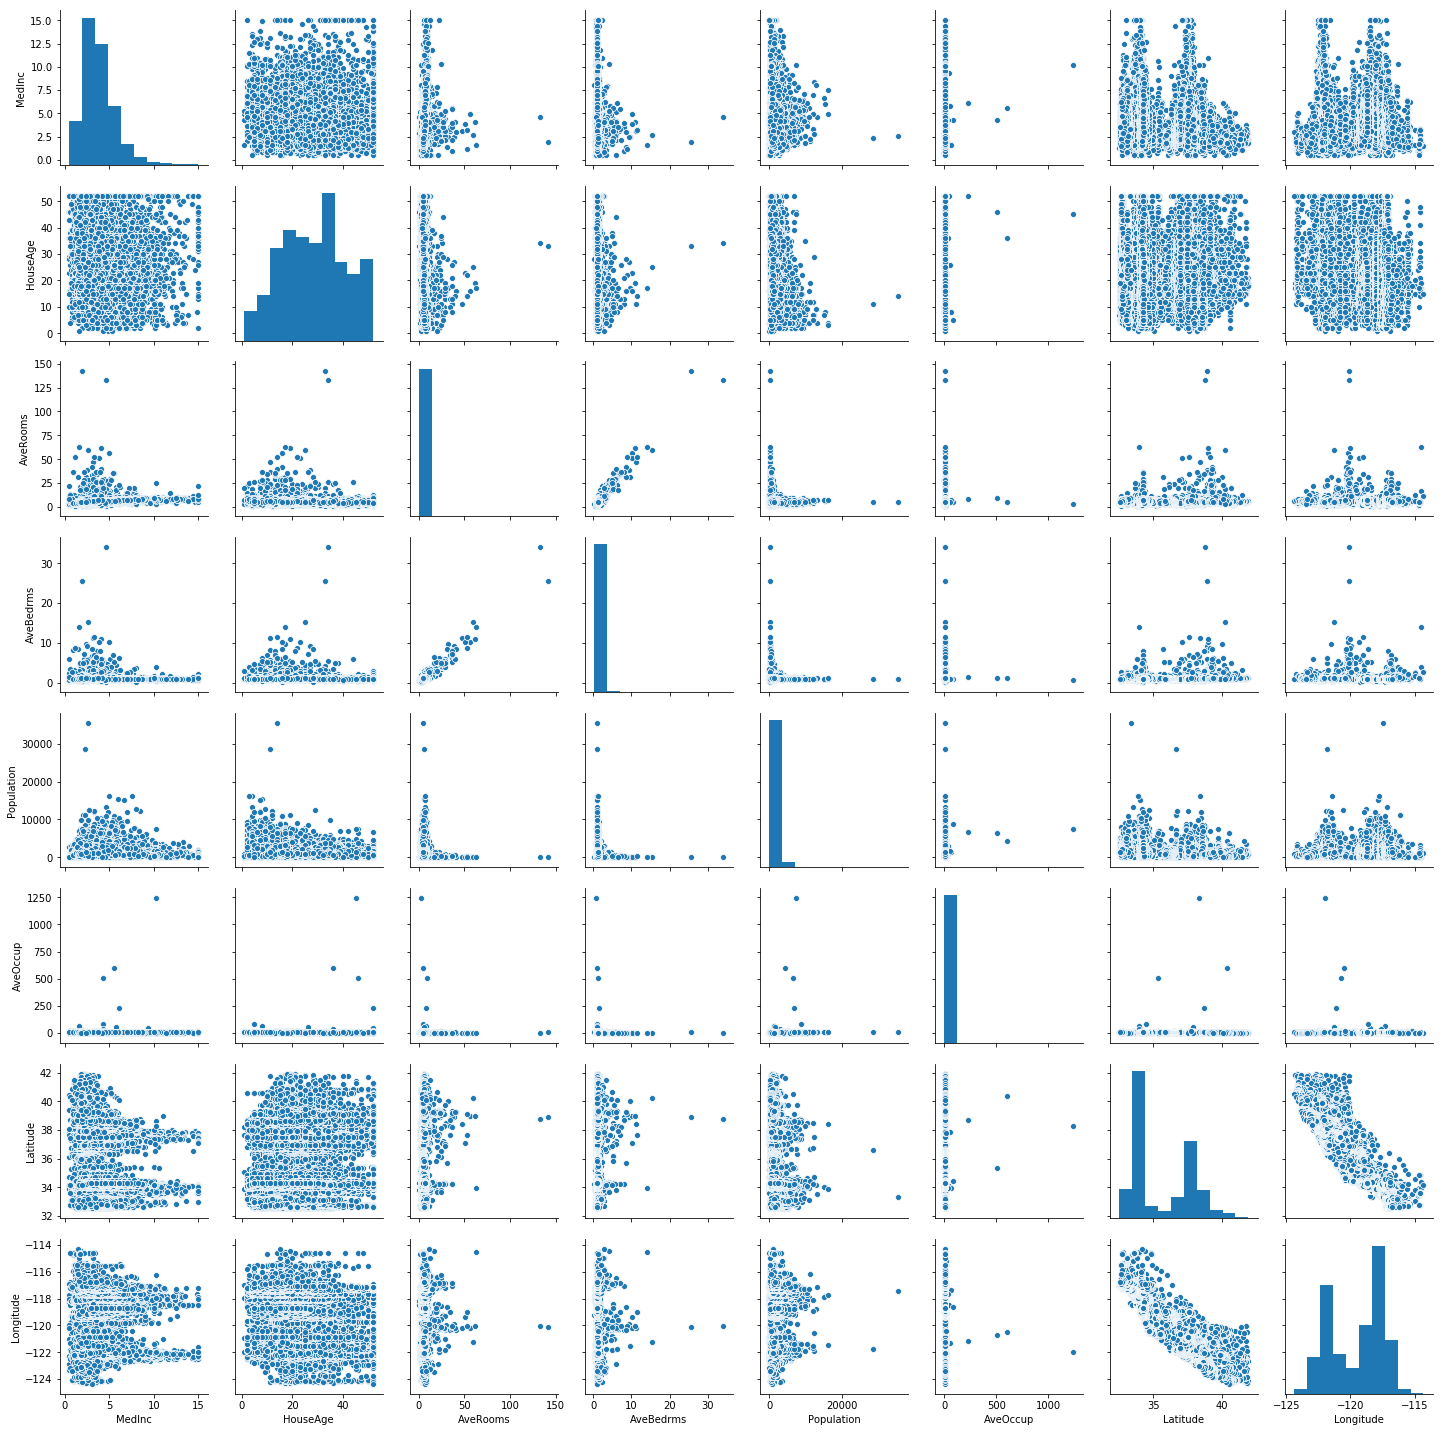

In [4]:
# Realizar una visualización general de la relación entre atributos del conjunto de datos
sns.pairplot(pd.DataFrame(cali_data.data, columns=cali_data.feature_names))
plt.show()

Con estas figuras se pueden observar algunas características interesantes:

- *Primero*, todas las variables importan en el modelo. Esto significa que el modelo de regresión viene pesado por todas las
  características y se requiere que el modelo sea *robusto* ante esta situación.
- *Segundo*, hay algunas características que tienen relación *lineal* entre ellas, como lo es **AveRooms** y **AveBedrms**.
  Esto puede ayudar a discriminar ciertas características que no tienen mucho peso sobre el modelo y solamente utilizar
  aquellas que influyen mucho más. A esta parte del *procesamiento de datos* se le conoce como **selección de características**
  y es una rama específica de la *inteligencia computacional.*
- *Tercero*, la línea diagonal muestra la relación *distribución* de cada una de las características. Esto es algo importante
  de estudiar dado que algunas características muestran *distribuciones* conocidas y este hecho se puede utilizar para
  emplear técnicas estadísticas más avanzadas en el **análisis de regresión.**

Sin embargo, en toda esta libreta se dejarán las 8 características para que sean pesadas en el modelo final.


In [5]:
# Separar todos los datos y estandarizarlos
X = cali_data.data
y = cali_data.target
# Crear el transformador para estandarización
std = preprocessing.StandardScaler()
X = std.fit_transform(X)
X = np.array(X).astype(np.float32)
y = std.fit_transform(y.reshape(-1, 1))
y = np.array(y).astype(np.float32)

Dado que los datos vienen en diferentes unidades y escalas, siempre se debe estandarizar los datos de alguna forma. En particular
en esta libreta se emplea la normalización de los datos, haciendo que tengan *media* $\mu = 0$ y *desviación estándar* $\sigma = 1$.


In [6]:
# Separar en conjunto de entrenamiento y prueba
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=49
)

In [7]:
# Definir parámetros generales de la Red Neuronal
pasos_entrenamiento = 1000
tam_lote = 30
ratio_aprendizaje = 0.01

## Estructura o *topología* de la red neuronal

Para esta regresión se pretende utilizar una *red neuronal* de **dos capas ocultas**, con *funciones de activación* **ReLU**,
la **primera** capa oculta cuenta con 25 neuronas mientras que la **segunda** cuenta con 50.
La **capa de salida** *no* tiene función de activación, por lo que el modelo lineal queda de la siguiente forma

$$ \hat{y}(x) = \sum_{i=1}^{8} \alpha_i \cdot x_i + \beta_i$$

donde $\alpha_i$ son los *pesos* de la *capa de salida*, mientras que $\beta_i$ son los *sesgos*.


In [8]:
# Parámetros para la estructura general de la red
# Número de neuronas por capa
n_capa_oculta_1 = 25
n_capa_oculta_2 = 50
n_entrada = X.shape[1]
n_salida = 1

In [9]:
# Definir las entradas de la red neuronal
x_entrada = tf.placeholder(tf.float32, shape=[None, n_entrada])
y_entrada = tf.placeholder(tf.float32, shape=[None, n_salida])

In [10]:
# Diccionario de pesos
pesos = {
    "o1": tf.Variable(tf.random_normal([n_entrada, n_capa_oculta_1])),
    "o2": tf.Variable(tf.random_normal([n_capa_oculta_1, n_capa_oculta_2])),
    "salida": tf.Variable(tf.random_normal([n_capa_oculta_2, n_salida])),
}
# Diccionario de sesgos
sesgos = {
    "b1": tf.Variable(tf.random_normal([n_capa_oculta_1])),
    "b2": tf.Variable(tf.random_normal([n_capa_oculta_2])),
    "salida": tf.Variable(tf.random_normal([n_salida])),
}

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
def propagacion_adelante(x):
    # Capa oculta 1
    # Esto es la mismo que Ax + b, un modelo lineal
    capa_1 = tf.add(tf.matmul(x, pesos["o1"]), sesgos["b1"])
    # ReLU como función de activación
    capa_1 = tf.nn.relu(capa_1)
    # Capa oculta 1
    # Esto es la mismo que Ax + b, un modelo lineal
    capa_2 = tf.add(tf.matmul(capa_1, pesos["o2"]), sesgos["b2"])
    # ReLU como función de activación
    capa_2 = tf.nn.relu(capa_2)

    # Capa de salida
    # Nuevamente, un modelo lineal
    capa_salida = tf.add(tf.matmul(capa_2, pesos["salida"]), sesgos["salida"])

    return capa_salida

In [12]:
# Implementar el modelo y sus capas
y_prediccion = propagacion_adelante(x_entrada)

## Función de pérdida

Para la función de pérdida se emplea la [función de Huber](https://en.wikipedia.org/wiki/Huber_loss) definida como

\begin{equation}
    L_{\delta} \left( y, f(x) \right) = 
    \begin{cases}
        \frac{1}{2} \left( y - f(x) \right)^2  & \text{para} \vert y - f(x) \vert \leq \delta, \\
        \delta \vert y - f(x) \vert - \frac{1}{2} \delta^2   & \text{en cualquier otro caso.}
    \end{cases}
\end{equation}

Esta función es [robusta](https://en.wikipedia.org/wiki/Robust_regression) lo cual está hecha para erradicar el peso de posibles
valores atípicos y puede encontrar la verdadera relación entre las características sin tener que recurrir a metodologías paramétricas
y no paramétricas.

## Nota

Es importante mencionar que el valor de $\delta$ en la función de Huber es un **hiperparámetro** que debe de ser ajustado mediante *validación cruzada*
pero no es realiza en esta libreta por limitaciones de equipo y rendimiento en la ejecución de esta libreta.


In [13]:
# Definir la función de costo
f_costo = tf.reduce_mean(tf.losses.huber_loss(y_entrada, y_prediccion, delta=2.0))
# f_costo = tf.reduce_mean(tf.square(y_entrada - y_prediccion))
optimizador = tf.train.AdamOptimizer(learning_rate=ratio_aprendizaje).minimize(f_costo)

Instructions for updating:
Use tf.cast instead.


In [14]:
# Primero, inicializar las variables
init = tf.global_variables_initializer()

In [15]:
# Función para evaluar la precisión de clasificación
def precision(prediccion, real):
    return tf.sqrt(tf.losses.mean_squared_error(real, prediccion))

## Precisión del modelo

Para evaluar la precisión del modelo se emplea la función [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (Root Mean Squared Error)
definida por la siguiente función:

$$ RMSE = \sqrt{\frac{\sum_{i=1}^{N} \left( \hat{y}_i - y_i \right)^2}{N}} $$

Para crear un mejor estimado, se empleará validación cruzada de 5 pliegues.


In [16]:
# Crear el plegador para el conjunto de datos
kf = model_selection.KFold(n_splits=5)
kf_val_score_train = []
kf_val_score_test = []

In [17]:
# Crear un grafo de computación
with tf.Session() as sess:
    # Inicializar las variables
    sess.run(init)

    for tr_idx, ts_idx in kf.split(x_train):
        # Comenzar los pasos de entrenamiento
        # solamente con el conjunto de datos de entrenamiento
        for p in range(pasos_entrenamiento):
            # Minimizar la función de costo
            minimizacion = sess.run(
                optimizador,
                feed_dict={x_entrada: x_train[tr_idx], y_entrada: y_train[tr_idx]},
            )
            # Cada tamaño de lote, calcular la precisión del modelo
            if p % tam_lote == 0:
                prec_entrenamiento = sess.run(
                    precision(y_prediccion, y_entrada),
                    feed_dict={x_entrada: x_train[tr_idx], y_entrada: y_train[tr_idx]},
                )
                kf_val_score_train.append(prec_entrenamiento)
                prec_prueba = sess.run(
                    precision(y_prediccion, y_entrada),
                    feed_dict={x_entrada: x_train[ts_idx], y_entrada: y_train[ts_idx]},
                )
                kf_val_score_test.append(prec_prueba)
    # Prediccion final, una vez entrenado el modelo
    pred_final = sess.run(
        precision(y_prediccion, y_entrada),
        feed_dict={x_entrada: x_test, y_entrada: y_test},
    )
    pred_report = sess.run(y_prediccion, feed_dict={x_entrada: x_test})
    print("Precisión final: {0}".format(pred_final))

Precisión final: 0.5226657390594482


In [18]:
print("Precisión RMSE para entrenamiento: {0}".format(np.mean(kf_val_score_train)))
print("Precisión RMSE para entrenamiento: {0}".format(np.mean(kf_val_score_test)))

Precisión RMSE para entrenamiento: 0.9006941914558411
Precisión RMSE para entrenamiento: 0.9006157517433167


Aquí se muestra el valor de *RMSE* final para cada parte, entrenamiento y prueba. Se puede observar que hay muy poco sobreajuste, 
y si se quisiera corregir se puede realizar aumentando el número de neuronas, de capas, cambiando las funciones de activación,
entre muchas otras cosas.

